In [110]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency
from scipy import stats

# Importing from cleaned data notebook

In [45]:
data = pd.read_csv('data_clean.csv')

In [46]:
data.head()

offer_accepted     reward mailer_type income_level  bank_accounts_open  \
0             No  Air Miles      Letter         High                   1   
1             No  Air Miles      Letter       Medium                   1   
2             No  Air Miles    Postcard         High                   2   
3             No  Air Miles      Letter       Medium                   2   
4             No  Air Miles      Letter       Medium                   1   

  overdraft_protection credit_rating  credit_cards_held  homes_owned  \
0                   No          High                  2            1   
1                   No        Medium                  2            2   
2                   No        Medium                  2            1   
3                   No          High                  1            1   
4                   No        Medium                  2            1   

   household_size own_your_home  average_balance  q1_balance  q2_balance  \
0               4            No          1160.75      1669.0       877.0   
1               5           Yes           147.25        39.0       106.0   
2               2           Yes           276.50       367.0       352.0   
3               4            No          1219.00      1578.0      1760.0   
4               6           Yes          1211.00      2140.0      1357.0   

   q3_balance  q4_balance  
0      1095.0      1002.0  
1        78.0       366.0  
2       145.0       242.0  
3      1119.0       419.0  
4       982.0       365.0

*Checking Shape and Value Counts*

In [47]:
data.shape

(18000, 16)

In [48]:
data["offer_accepted"].value_counts()

No     16977
Yes     1023
Name: offer_accepted, dtype: int64

# Splitting numericals and categoricals

In [49]:
cat_columns = []
num_columns = []

for i in data.columns:
    if len(data[i].unique()) > 10:
        num_columns.append(i)
    else:
        cat_columns.append(i)

In [50]:
num = data[num_columns]
num.head()

average_balance  q1_balance  q2_balance  q3_balance  q4_balance
0          1160.75      1669.0       877.0      1095.0      1002.0
1           147.25        39.0       106.0        78.0       366.0
2           276.50       367.0       352.0       145.0       242.0
3          1219.00      1578.0      1760.0      1119.0       419.0
4          1211.00      2140.0      1357.0       982.0       365.0

In [51]:
cat = data[cat_columns]
cat.head()

offer_accepted     reward mailer_type income_level  bank_accounts_open  \
0             No  Air Miles      Letter         High                   1   
1             No  Air Miles      Letter       Medium                   1   
2             No  Air Miles    Postcard         High                   2   
3             No  Air Miles      Letter       Medium                   2   
4             No  Air Miles      Letter       Medium                   1   

  overdraft_protection credit_rating  credit_cards_held  homes_owned  \
0                   No          High                  2            1   
1                   No        Medium                  2            2   
2                   No        Medium                  2            1   
3                   No          High                  1            1   
4                   No        Medium                  2            1   

   household_size own_your_home  
0               4            No  
1               5           Yes  
2               2           Yes  
3               4            No  
4               6           Yes

# Exploration on Numericals

In [52]:
for i in num.columns:
    print(num[i].describe())

count    18000.000000
mean       940.604208
std        350.072621
min         48.250000
25%        787.937500
50%       1007.000000
75%       1152.562500
max       3366.250000
Name: average_balance, dtype: float64
count    18000.000000
mean       910.266056
std        619.684111
min          0.000000
25%        393.000000
50%        772.000000
75%       1520.250000
max       3450.000000
Name: q1_balance, dtype: float64
count    18000.000000
mean       999.435667
std        457.098763
min          0.000000
25%        664.000000
50%       1032.000000
75%       1342.000000
max       3421.000000
Name: q2_balance, dtype: float64
count    18000.000000
mean      1041.904889
std        553.094705
min          0.000000
25%        633.000000
50%        945.500000
75%       1462.000000
max       3823.000000
Name: q3_balance, dtype: float64
count    18000.000000
mean       810.042889
std        558.642246
min          0.000000
25%        363.750000
50%        703.000000
75%       1211.000000
max  

*Looking at the values of the quarterly qverages, we can notice the numbers tend to be similar. The next step is to check Multicollinearity and VIF.*

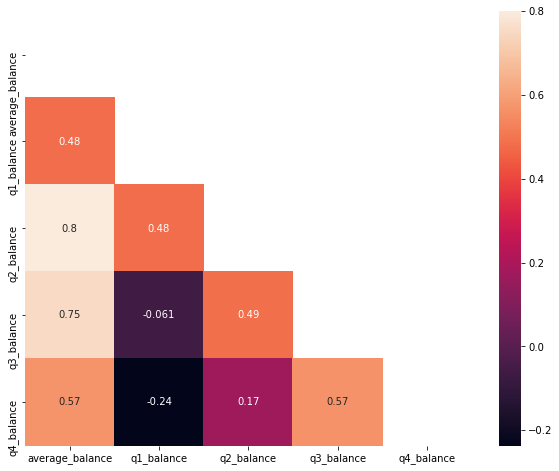

In [53]:
correlations_matrix = num.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

*Multicollinearity shows generally values above 0.50. VIF is useful to check the relation between the quarterly values and all other columns.*

In [54]:
vif = {}
num_vif = num
num_vif= add_constant(num)

In [55]:
for i in np.arange(num_vif.shape[1]):
    column_name = num_vif.columns[i]
    value = variance_inflation_factor(np.array(num_vif), i)
    vif[column_name] = value
vif  

{'const': 8.268845743264174,
 'average_balance': 4447.523660455172,
 'q1_balance': 871.3913136229564,
 'q2_balance': 476.80592208638893,
 'q3_balance': 695.2171601202452,
 'q4_balance': 709.0042955328568}

# Feature Engineering for Numericals

*VIF shows high correlation for the Q-averages, so useful information from these columns can be assembled in an alternative way.* 
<br>

*max_quarter/min_quarter are the quarters with the highest and lowest balances*
<br>
*max/min are the highest and lowest balances*
<br>
*range is the difference between max and min balances and showing the variability of balance during the year*

In [56]:
#defining function for adding the new features
def minmax_func(df):
    max_q = df.idxmax(axis=1)
    min_q = df.idxmin(axis=1)
    max_ = df.max(axis=1)
    min_ = df.min(axis=1)
    range_ = (df.max(axis=1))-(df.min(axis=1))
    
    
    df["max_quarter"] = max_q
    df["min_quarter"] = min_q
    df["range"] = range_
    df["max"] = max_
    df["min"] = min_
    
    return df
   
num = minmax_func(num)

In [57]:
#renaming the columns with the quarters
num['max_quarter'] = list(map(lambda x: x[:2],num['max_quarter']))
num['min_quarter'] = list(map(lambda x: x[:2],num['min_quarter']))

In [58]:
#add new min_quarter/max_quarter columns to the categorical data and drop from numerical
cat = data[cat_columns]
cat["max_quarter"] = num["max_quarter"]
cat["min_quarter"] = num["min_quarter"]
num = num.drop(["max_quarter", "min_quarter"], axis = 1)

In [59]:
num.head()

average_balance  q1_balance  q2_balance  q3_balance  q4_balance   range  \
0          1160.75      1669.0       877.0      1095.0      1002.0   792.0   
1           147.25        39.0       106.0        78.0       366.0   327.0   
2           276.50       367.0       352.0       145.0       242.0   222.0   
3          1219.00      1578.0      1760.0      1119.0       419.0  1341.0   
4          1211.00      2140.0      1357.0       982.0       365.0  1775.0   

      max    min  
0  1669.0  877.0  
1   366.0   39.0  
2   367.0  145.0  
3  1760.0  419.0  
4  2140.0  365.0

*Checking Multicollinearity including the new features*

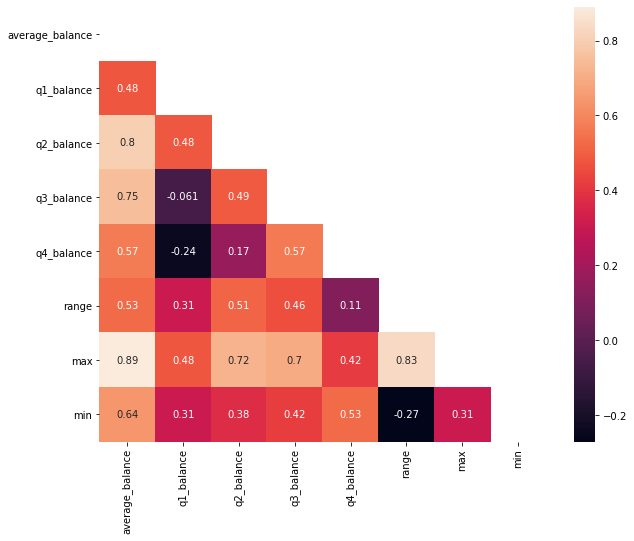

In [60]:
correlations_matrix = num.corr()
mask = np.zeros_like(correlations_matrix) 
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

In [61]:
# "max" correlates strongly with avg balance and range so remove
# q1,q2,q4 do not appear as relevant in the modeling process, so we remove
num = num.drop(["max", "q1_balance", "q2_balance","q4_balance"], axis = 1)

In [62]:
num.head()

average_balance  q3_balance   range    min
0          1160.75      1095.0   792.0  877.0
1           147.25        78.0   327.0   39.0
2           276.50       145.0   222.0  145.0
3          1219.00      1119.0  1341.0  419.0
4          1211.00       982.0  1775.0  365.0

*Correlation between numerical variables and target*

In [70]:
#create temporary dataframe including numerical features and target variable
num_target = num
num_target['offer_accepted'] = data['offer_accepted']
num_target.head()

average_balance  q3_balance   range    min offer_accepted
0          1160.75      1095.0   792.0  877.0             No
1           147.25        78.0   327.0   39.0             No
2           276.50       145.0   222.0  145.0             No
3          1219.00      1119.0  1341.0  419.0             No
4          1211.00       982.0  1775.0  365.0             No

In [71]:
#this line is to remove "offer_accepted" which is strangely added to "num" by the lines above
num = num.drop(["offer_accepted"], axis = 1)

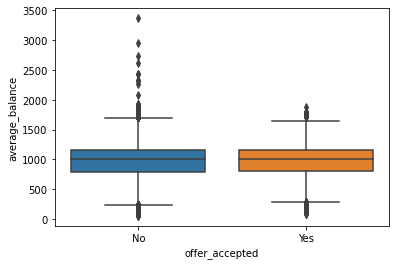

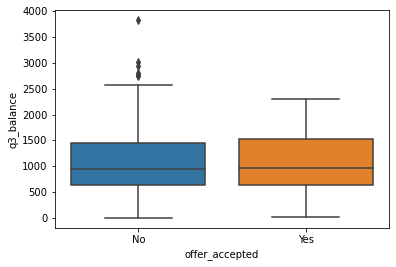

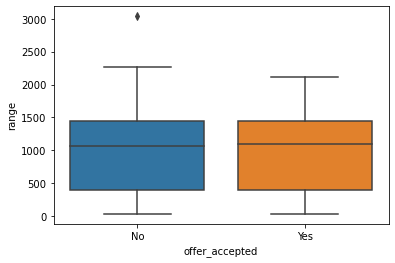

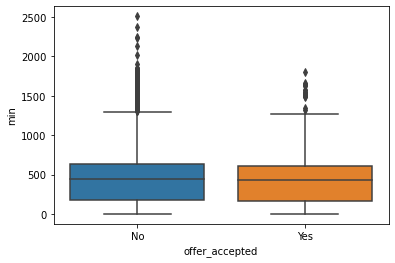

In [73]:
for i in num_target:
    if i != 'offer_accepted':
        sns.boxplot(x="offer_accepted", y=i, data = num_target)
        plt.show()
    else:
        continue
#result: here it is possible to see the relationship between q3_balance and the target variable

# Exploration on Categoricals

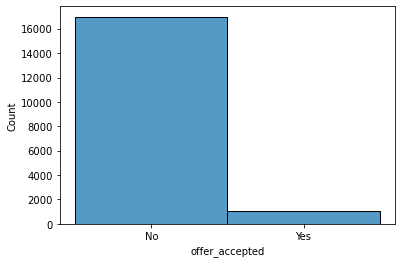

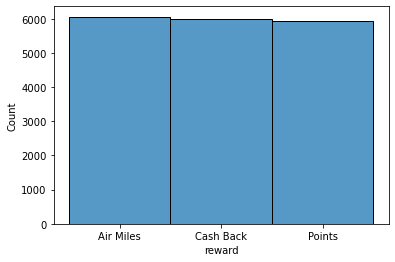

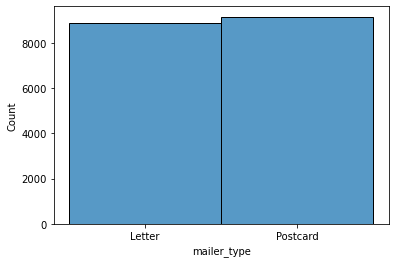

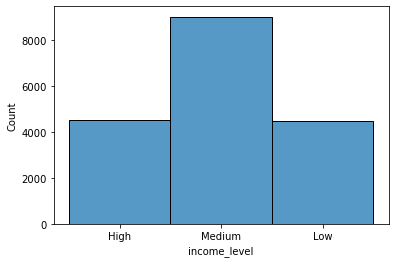

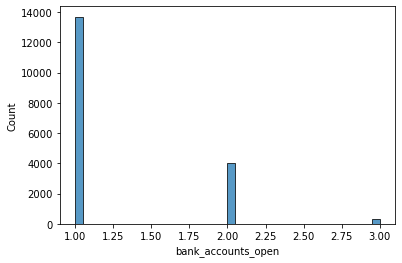

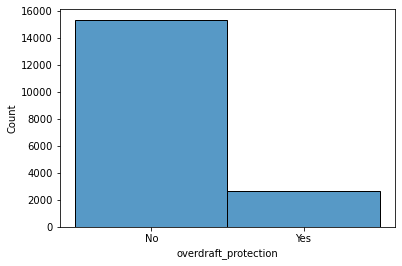

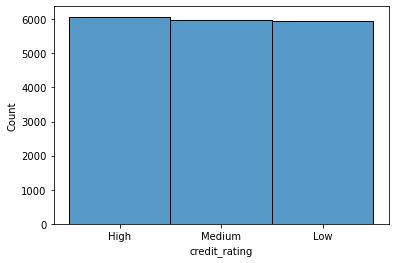

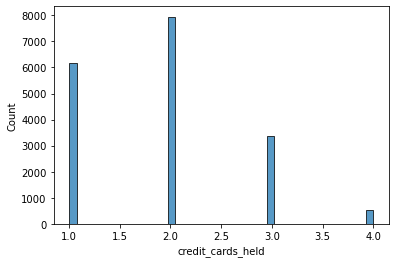

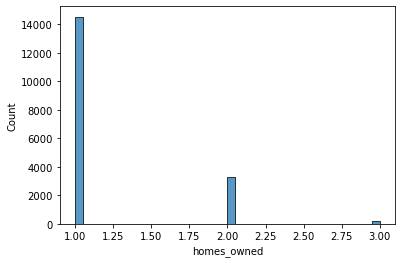

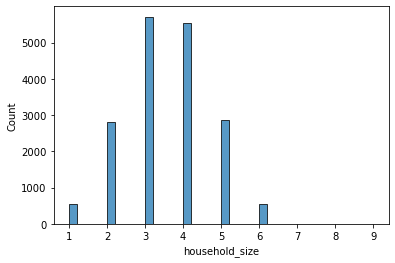

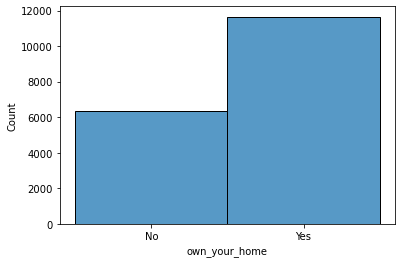

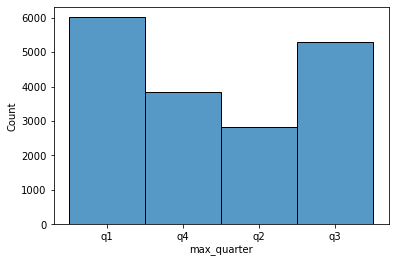

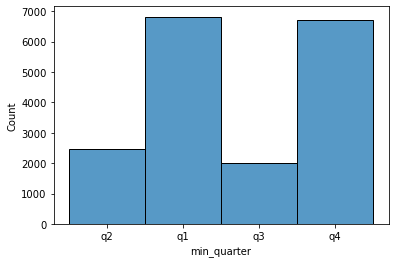

In [74]:
for i in range(cat.shape[1]):
    sns.histplot(cat[cat.columns[i]], bins=40)
    plt.show()

*Checking other columns with multiple values to decide whether to group or keep all categories.*

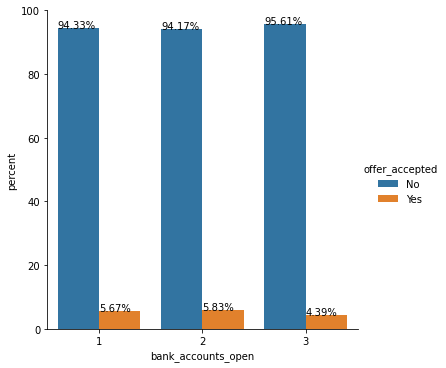

In [75]:
#relative percentages for bank_accounts_open by offer_accepted
x_ , y_ = 'bank_accounts_open', 'offer_accepted'
temp_df = cat.groupby(x_)[y_].value_counts(normalize=True)
temp_df = temp_df.mul(100)
temp_df = temp_df.rename('percent').reset_index()
g = sns.catplot(x=x_,y='percent',hue=y_, kind='bar',data=temp_df)
g.ax.set_ylim(0,100)
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [76]:
cat.head()

offer_accepted     reward mailer_type income_level  bank_accounts_open  \
0             No  Air Miles      Letter         High                   1   
1             No  Air Miles      Letter       Medium                   1   
2             No  Air Miles    Postcard         High                   2   
3             No  Air Miles      Letter       Medium                   2   
4             No  Air Miles      Letter       Medium                   1   

  overdraft_protection credit_rating  credit_cards_held  homes_owned  \
0                   No          High                  2            1   
1                   No        Medium                  2            2   
2                   No        Medium                  2            1   
3                   No          High                  1            1   
4                   No        Medium                  2            1   

   household_size own_your_home max_quarter min_quarter  
0               4            No          q1          q2  
1               5           Yes          q4          q1  
2               2           Yes          q1          q3  
3               4            No          q2          q4  
4               6           Yes          q1          q4

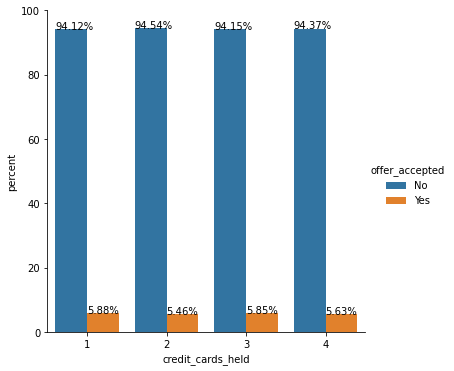

In [77]:
#relative percentages for credit_cards_held by offer_accepted
x_,y_ = 'credit_cards_held', 'offer_accepted'
temp_df = cat.groupby(x_)[y_].value_counts(normalize=True)
temp_df = temp_df.mul(100)
temp_df = temp_df.rename('percent').reset_index()
g = sns.catplot(x=x_, y='percent', hue=y_, kind='bar', data=temp_df)
g.ax.set_ylim(0,100)
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

*Replacing low frequency values in household_size and clustering them*

In [78]:
cat['household_size'] = cat['household_size'].apply(lambda x: 6 if x>6 else x)

In [79]:
#create new dataframe dropping the target variable
cat_no_target = cat.drop(['offer_accepted'], axis = 1)
cat_no_target.shape

(18000, 12)

In [80]:
cat_no_target.head()

reward mailer_type income_level  bank_accounts_open  \
0  Air Miles      Letter         High                   1   
1  Air Miles      Letter       Medium                   1   
2  Air Miles    Postcard         High                   2   
3  Air Miles      Letter       Medium                   2   
4  Air Miles      Letter       Medium                   1   

  overdraft_protection credit_rating  credit_cards_held  homes_owned  \
0                   No          High                  2            1   
1                   No        Medium                  2            2   
2                   No        Medium                  2            1   
3                   No          High                  1            1   
4                   No        Medium                  2            1   

   household_size own_your_home max_quarter min_quarter  
0               4            No          q1          q2  
1               5           Yes          q4          q1  
2               2           Yes          q1          q3  
3               4            No          q2          q4  
4               6           Yes          q1          q4

*Check chi-squared value of all pairs of categorical variables*

In [82]:
#function to check chi squared value for all pairs of columns in a dataframe
def chi2_check (data):
    lst1 = []
    lst2 = []
    lst3 = []
    for i,n in enumerate(data.columns):
        x = 1
        while x < len(data.columns)-i: 
            crosstab = pd.crosstab(data[n],data[data.columns[i+x]])
            lst1.append(n)
            lst2.append(data.columns[i+x])
            lst3.append(chi2_contingency(crosstab, correction=False)[1])
            x += 1
    df = pd.concat([pd.DataFrame(lst1),pd.DataFrame(lst2),pd.DataFrame(lst3)], axis =1)
    return df


cat_chi2 = chi2_check(cat_no_target)

#check which pairs of columns have a p value < 0.05, which means a high correlation
cat_chi2[cat_chi2.iloc[:,2]<0.05]

0            0         0
19        mailer_type  max_quarter  0.007761
49      credit_rating  max_quarter  0.008498
50      credit_rating  min_quarter  0.013072
54  credit_cards_held  max_quarter  0.009283
65        max_quarter  min_quarter  0.000000

In [84]:
#drop "max_quarter" and "min_quarter" from cat as they are correlated with each other and other categorical variables
cat = cat.drop(["max_quarter", "min_quarter"], axis=1)
cat.head()

offer_accepted     reward mailer_type income_level  bank_accounts_open  \
0             No  Air Miles      Letter         High                   1   
1             No  Air Miles      Letter       Medium                   1   
2             No  Air Miles    Postcard         High                   2   
3             No  Air Miles      Letter       Medium                   2   
4             No  Air Miles      Letter       Medium                   1   

  overdraft_protection credit_rating  credit_cards_held  homes_owned  \
0                   No          High                  2            1   
1                   No        Medium                  2            2   
2                   No        Medium                  2            1   
3                   No          High                  1            1   
4                   No        Medium                  2            1   

   household_size own_your_home  
0               4            No  
1               5           Yes  
2               2           Yes  
3               4            No  
4               6           Yes

*Chi Squared between categorical variables and target to check for correlation*

In [85]:
#check chi-squared values of all pairs of categorical variables and target
cat_target_chi2 = chi2_check(cat)

In [86]:
#check which categorical columns are not correlated with target "offer accepted" (p>0.05)
cat_target_chi2[(cat_target_chi2.iloc[:,0]=='offer_accepted')&(cat_target_chi2.iloc[:,2]>0.05)]

0                     0         0
3  offer_accepted    bank_accounts_open  0.578715
4  offer_accepted  overdraft_protection  0.704005
6  offer_accepted     credit_cards_held  0.719141
7  offer_accepted           homes_owned  0.881636
8  offer_accepted        household_size  0.094232
9  offer_accepted         own_your_home  0.967346

In [87]:
#Drop above columns since they are not related to the target
cat = cat.drop(["bank_accounts_open", "overdraft_protection", "credit_cards_held", "homes_owned", "own_your_home"], axis = 1)

*Plot to show the chi square relation of categorical variables to Target Variable.*

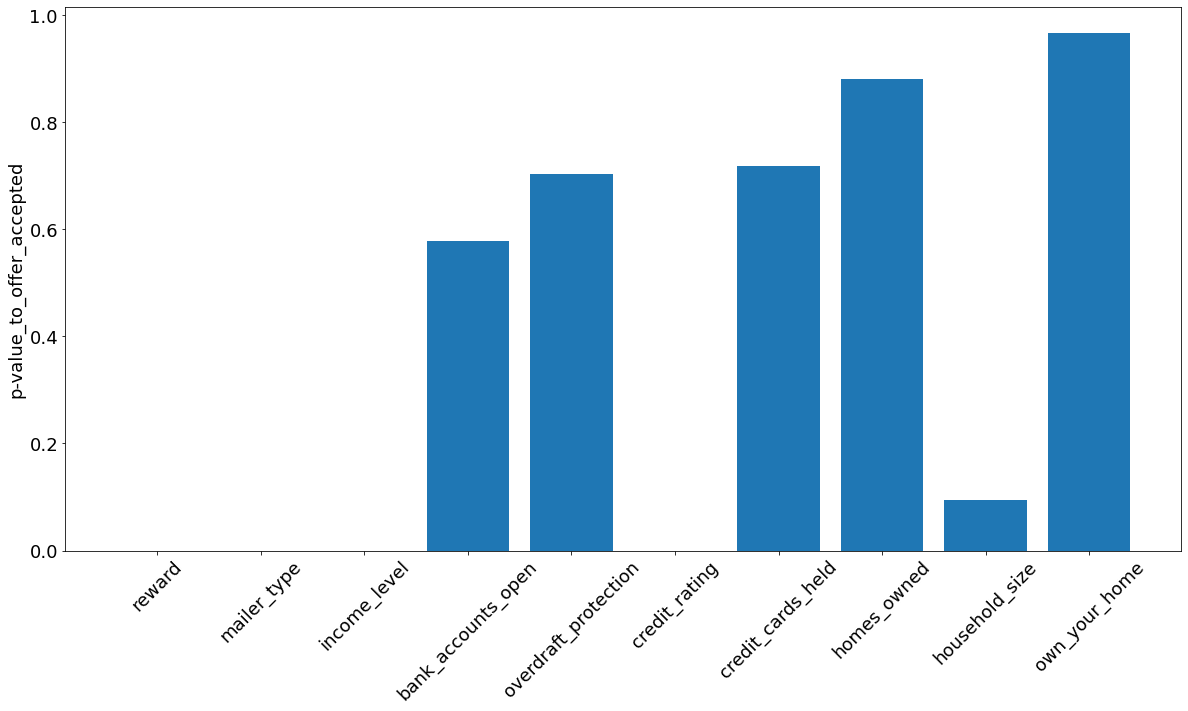

In [88]:
plt.figure(figsize=(20,10))
plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)
plt.ylabel('p-value_to_offer_accepted', fontsize=18)
plt.bar(cat_target_chi2.iloc[0:10,1],cat_target_chi2.iloc[0:10,2])
plt.show()
#drop categories with bars

In [89]:
#Concatenate num and cat
data = pd.concat([cat, num], axis =1)

In [90]:
data.head()

offer_accepted     reward mailer_type income_level credit_rating  \
0             No  Air Miles      Letter         High          High   
1             No  Air Miles      Letter       Medium        Medium   
2             No  Air Miles    Postcard         High        Medium   
3             No  Air Miles      Letter       Medium          High   
4             No  Air Miles      Letter       Medium        Medium   

   household_size  average_balance  q3_balance   range    min  
0               4          1160.75      1095.0   792.0  877.0  
1               5           147.25        78.0   327.0   39.0  
2               2           276.50       145.0   222.0  145.0  
3               4          1219.00      1119.0  1341.0  419.0  
4               6          1211.00       982.0  1775.0  365.0

# Numericals vs Categoricals

*Check categorical variables against numericals, excluding the target.*

In [91]:
#drop target variable
cat_no_target = cat.drop(['offer_accepted'], axis = 1)

In [92]:
cat_no_target.head()

reward mailer_type income_level credit_rating  household_size
0  Air Miles      Letter         High          High               4
1  Air Miles      Letter       Medium        Medium               5
2  Air Miles    Postcard         High        Medium               2
3  Air Miles      Letter       Medium          High               4
4  Air Miles      Letter       Medium        Medium               6

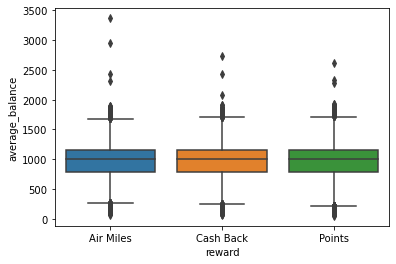

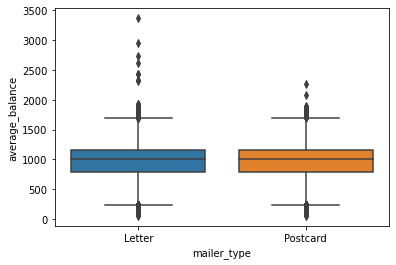

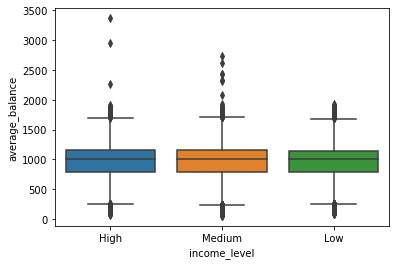

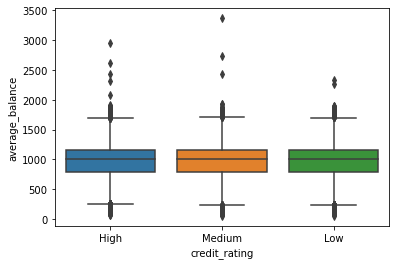

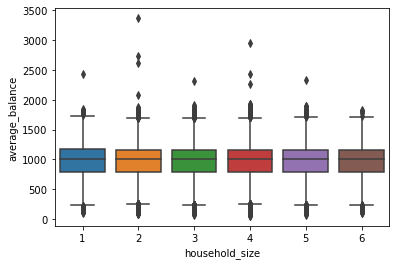

In [93]:
#Check average_balance against categorical variables(exclude target)
for i in cat_no_target:
    sns.boxplot(x=i, y="average_balance", data = data)
    plt.show()

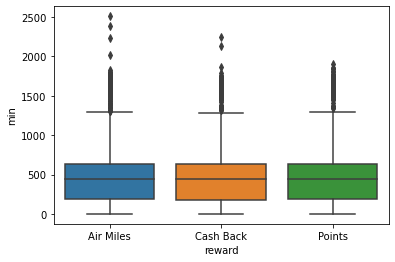

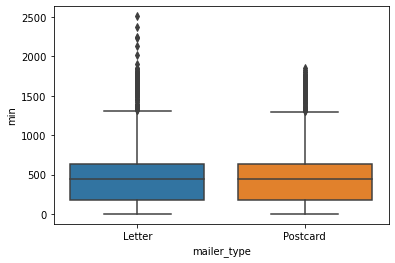

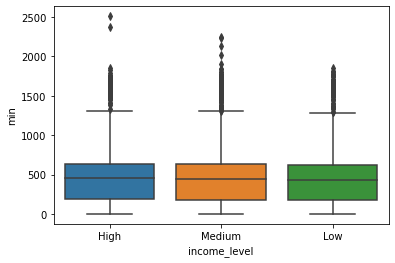

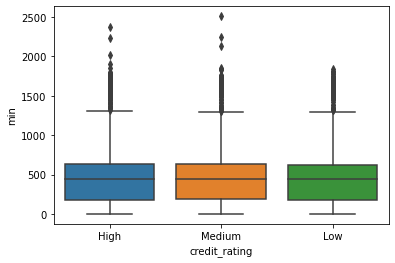

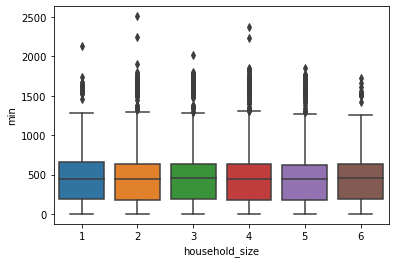

In [94]:
#check min against categorical variables
for i in cat_no_target:
    sns.boxplot(x=i, y="min", data = data)
    plt.show()

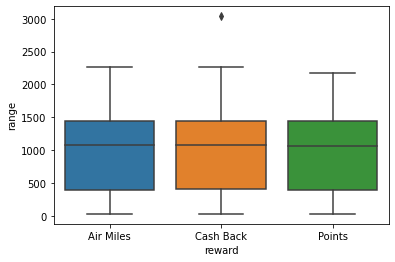

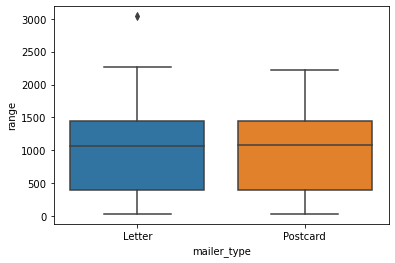

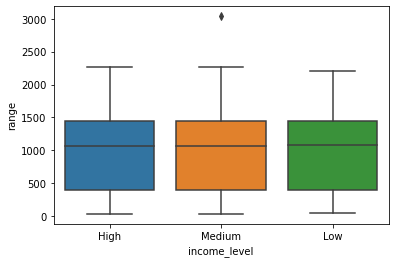

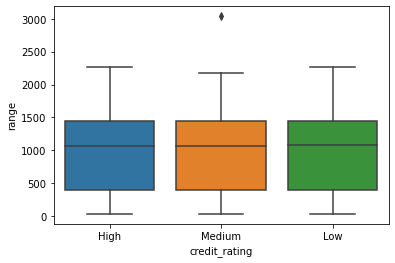

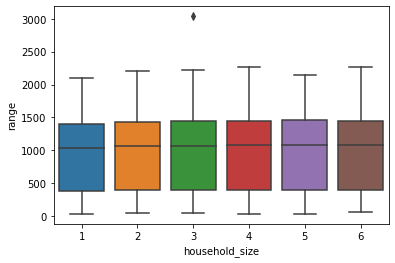

In [95]:
#check range against categorical variables
for i in cat_no_target:
    sns.boxplot(x=i, y="range", data = data)
    plt.show()

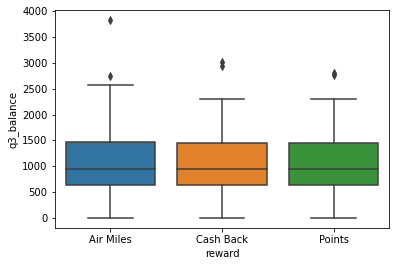

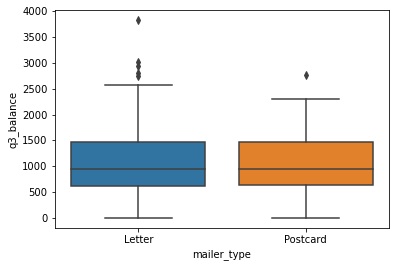

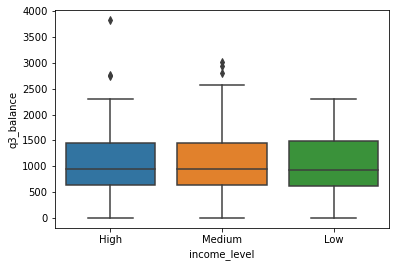

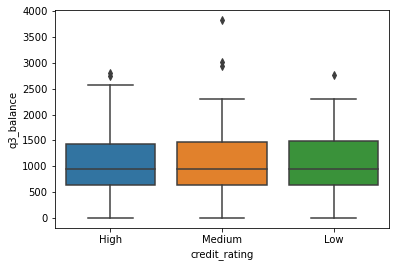

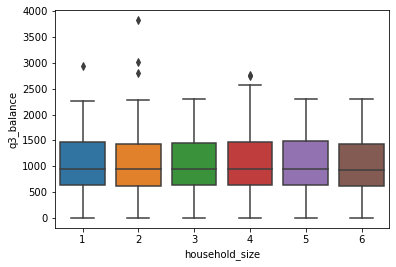

In [96]:
#check q3 against categorical variables
for i in cat_no_target:
    sns.boxplot(x=i, y="q3_balance", data = data)
    plt.show()

*Result: no multicollinearity between categorical and numerical variables was found*

# Removing Outliers

*Plo

In [97]:
#check distribution of target variable before removing outliers
data["offer_accepted"].value_counts()

No     16977
Yes     1023
Name: offer_accepted, dtype: int64

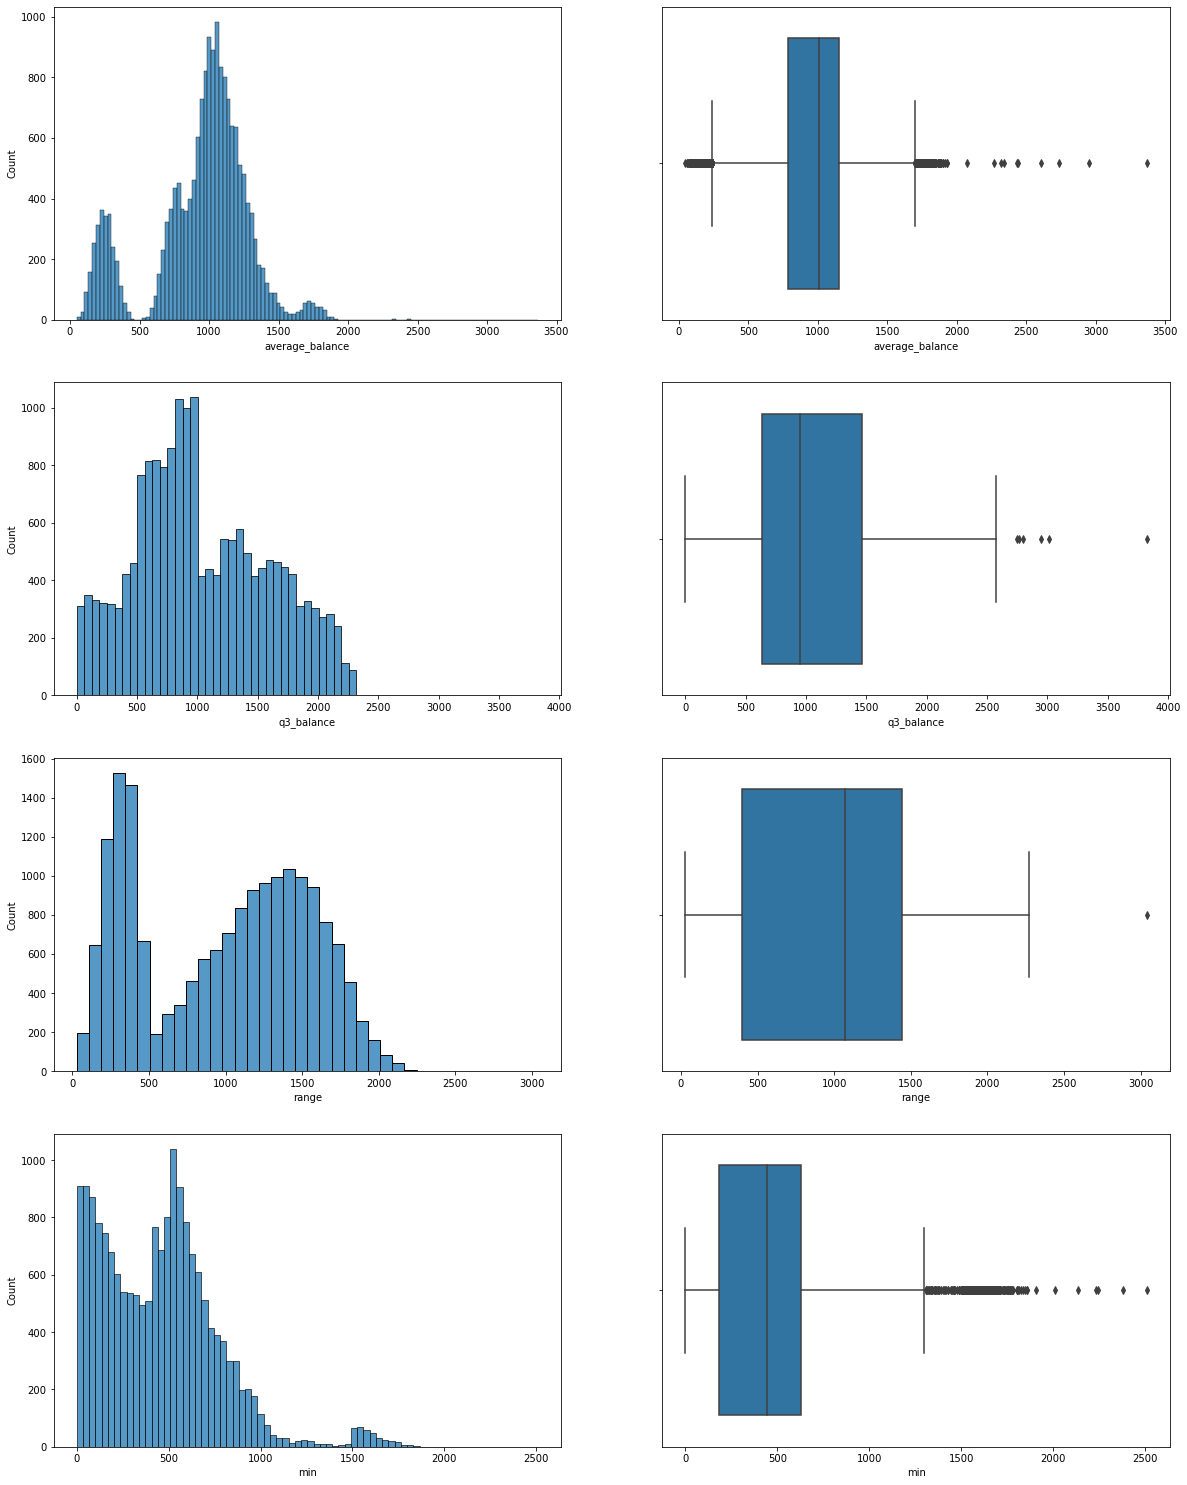

In [98]:
#show plots of distribution and boxplot for each remaining numerical feature
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2,figsize = (20, 20)) 
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 

sns.histplot(data["average_balance"], ax=ax1)
sns.boxplot(data['average_balance'], ax=ax2)
sns.histplot(data['q3_balance'], ax=ax3)
sns.boxplot(data['q3_balance'], ax=ax4)
sns.histplot(data['range'], ax=ax5)
sns.boxplot(data['range'], ax=ax6)
sns.histplot(data['min'], ax=ax7)
sns.boxplot(data['min'], ax=ax8)


plt.show()

In [99]:
#function to remove outliers given the dataframe, column and k constant which adjusts the upper and lower limits
def remove_outliers(df, x, k):
    iqr = np.percentile(df[x],75) - np.percentile(df[x],25)
    upper_limit = np.percentile(df[x],75) + k*iqr
    lower_limit = np.percentile(df[x],25) - k*iqr
    df = df[(df[x]>lower_limit) & (df[x]<upper_limit)]
    return df

In [100]:
#remove outliers from dataframe. k values have been chosen to balance the amount of data removed with the amount of outliers removed

data = remove_outliers (data, 'average_balance', 1.5)
data = remove_outliers (data, 'min', 1.5)
data = remove_outliers (data, 'q3_balance', 1)


In [102]:
#~70 "yes" are removed
data["offer_accepted"].value_counts()

No     15327
Yes      924
Name: offer_accepted, dtype: int64

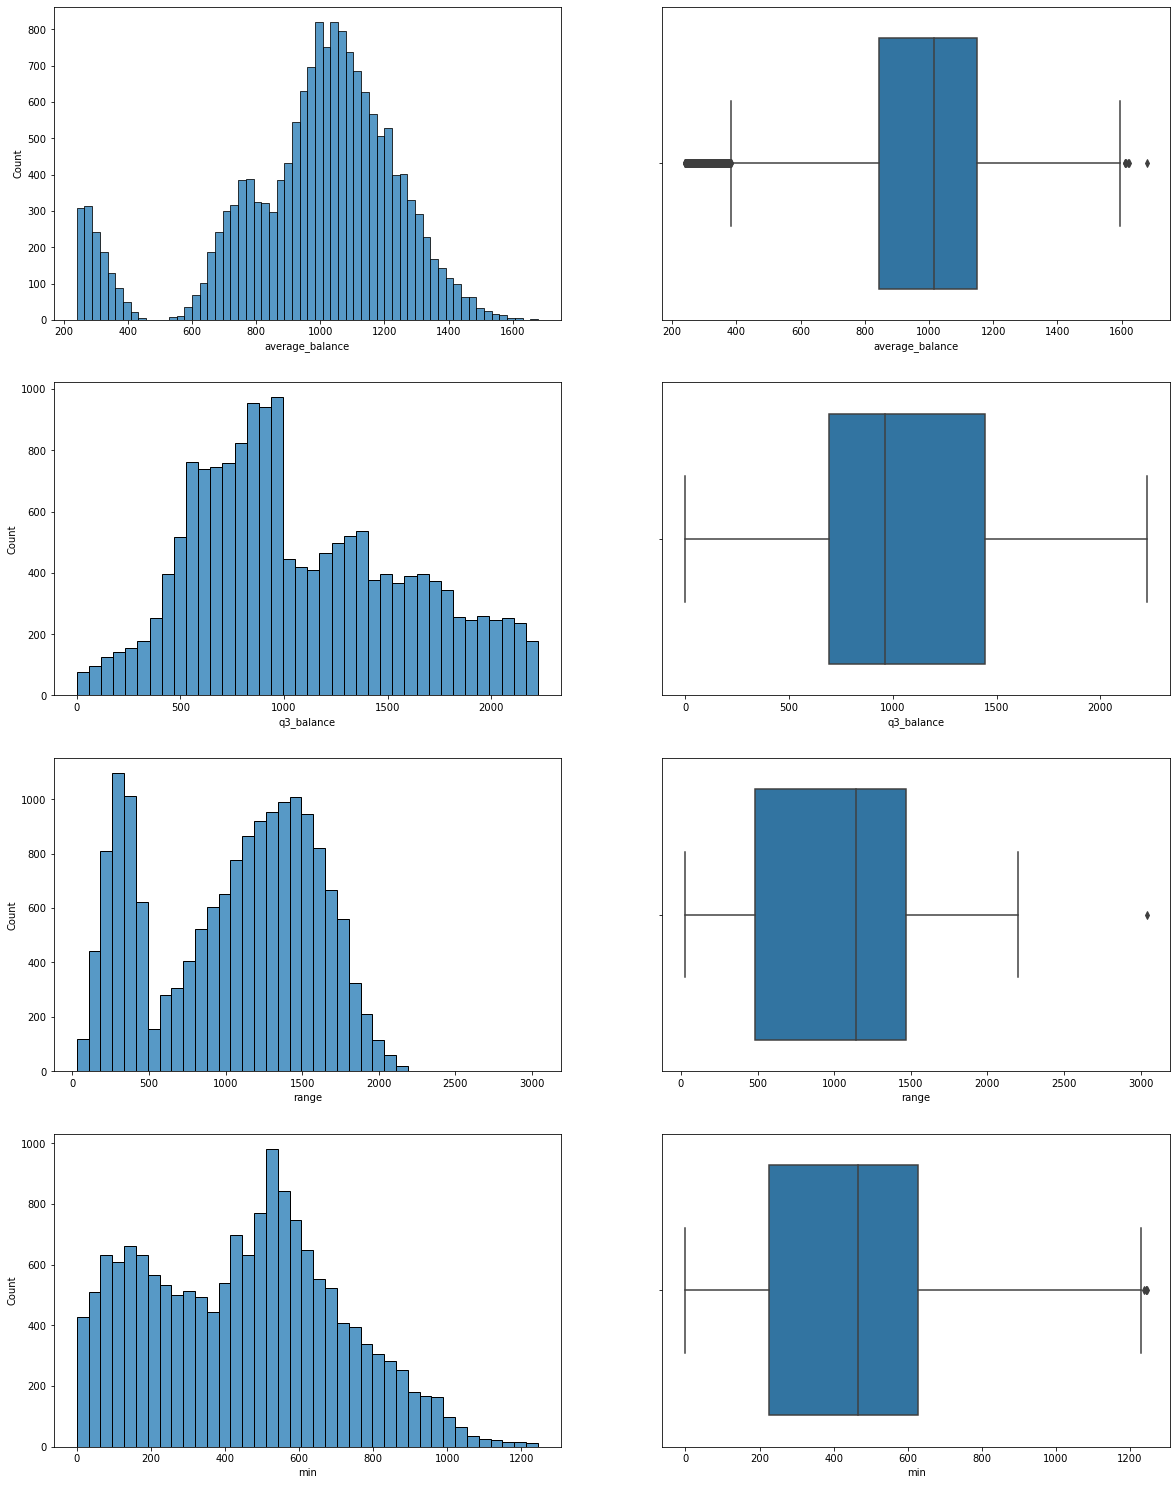

In [104]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2,figsize = (20, 20)) 
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 

sns.histplot(data["average_balance"], ax=ax1)
sns.boxplot(data['average_balance'], ax=ax2)
sns.histplot(data['q3_balance'], ax=ax3)
sns.boxplot(data['q3_balance'], ax=ax4)
sns.histplot(data['range'], ax=ax5)
sns.boxplot(data['range'], ax=ax6)
sns.histplot(data['min'], ax=ax7)
sns.boxplot(data['min'], ax=ax8)

plt.show()

Splitting numericals and categoricals again for transformations and encoding

In [105]:
cat_columns = []
num_columns = []

for i in data.columns:
    if len(data[i].unique()) > 10:
        num_columns.append(i)
    else:
        cat_columns.append(i)   

num = data[num_columns]
cat = data[cat_columns]

Numericals - applying transformations, tested log, BoxCox and Square Root

In [108]:
#function to take log of values in a column and return 0 for values <0
def log_transform_clean(x):
    if x>0:
        return np.log(x)
    else:
        return 0  

In [106]:
#checking transformations of min
def transformations (data, name):

    data[name+"_sqrt"] = data[name]**(1/2)
    data[name+"_log"] = list(map(log_transform_clean, data[name]))

    if data[name].min() > 0:
        box_cox, lmbda = stats.boxcox(data[name])
        data[name+"_bc"]= box_cox

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20,15)) 
        plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
        sns.histplot(data[name], ax=ax1)
        sns.histplot(data[name+"_sqrt"], ax=ax2)
        sns.histplot(data[name+"_log"], ax=ax3)
        sns.histplot(data[name+"_bc"], ax=ax4)
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,5)) 
        plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
        sns.histplot(data[name], ax=ax1)
        sns.histplot(data[name+"_sqrt"], ax=ax2)
        sns.histplot(data[name+"_log"], ax=ax3)
    return data

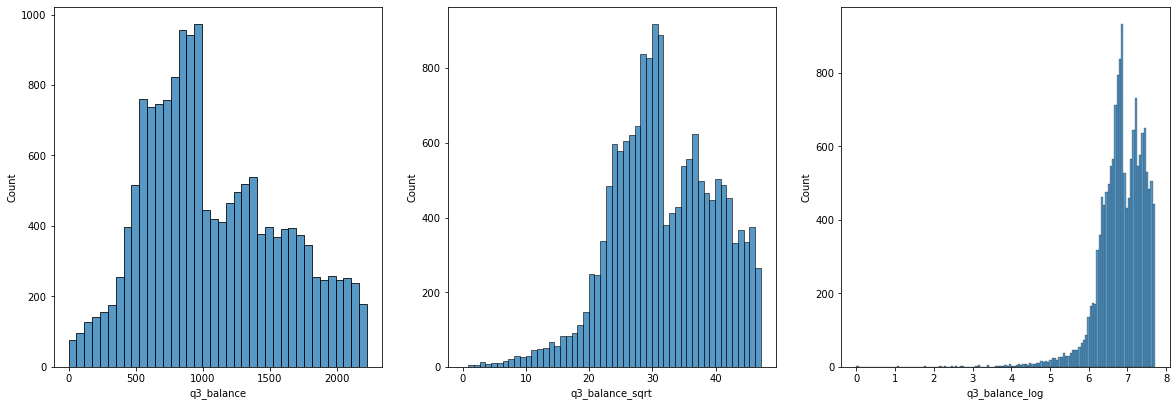

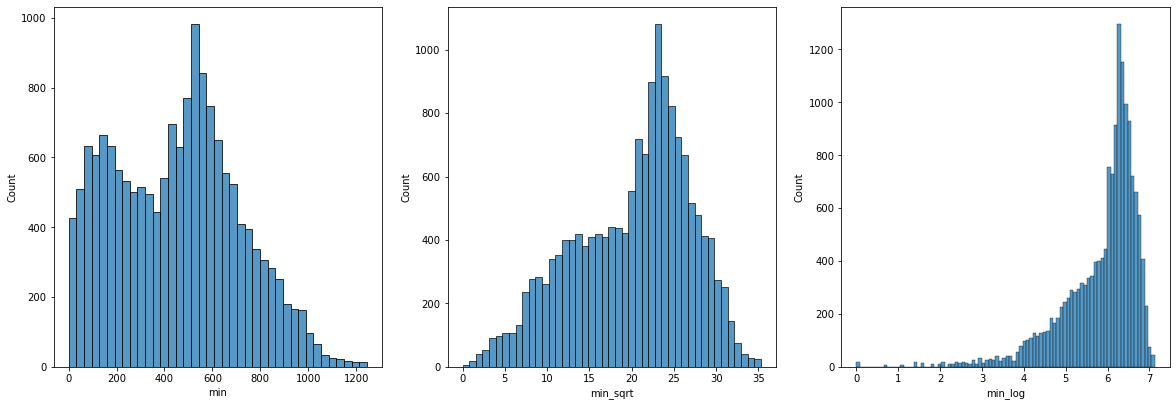

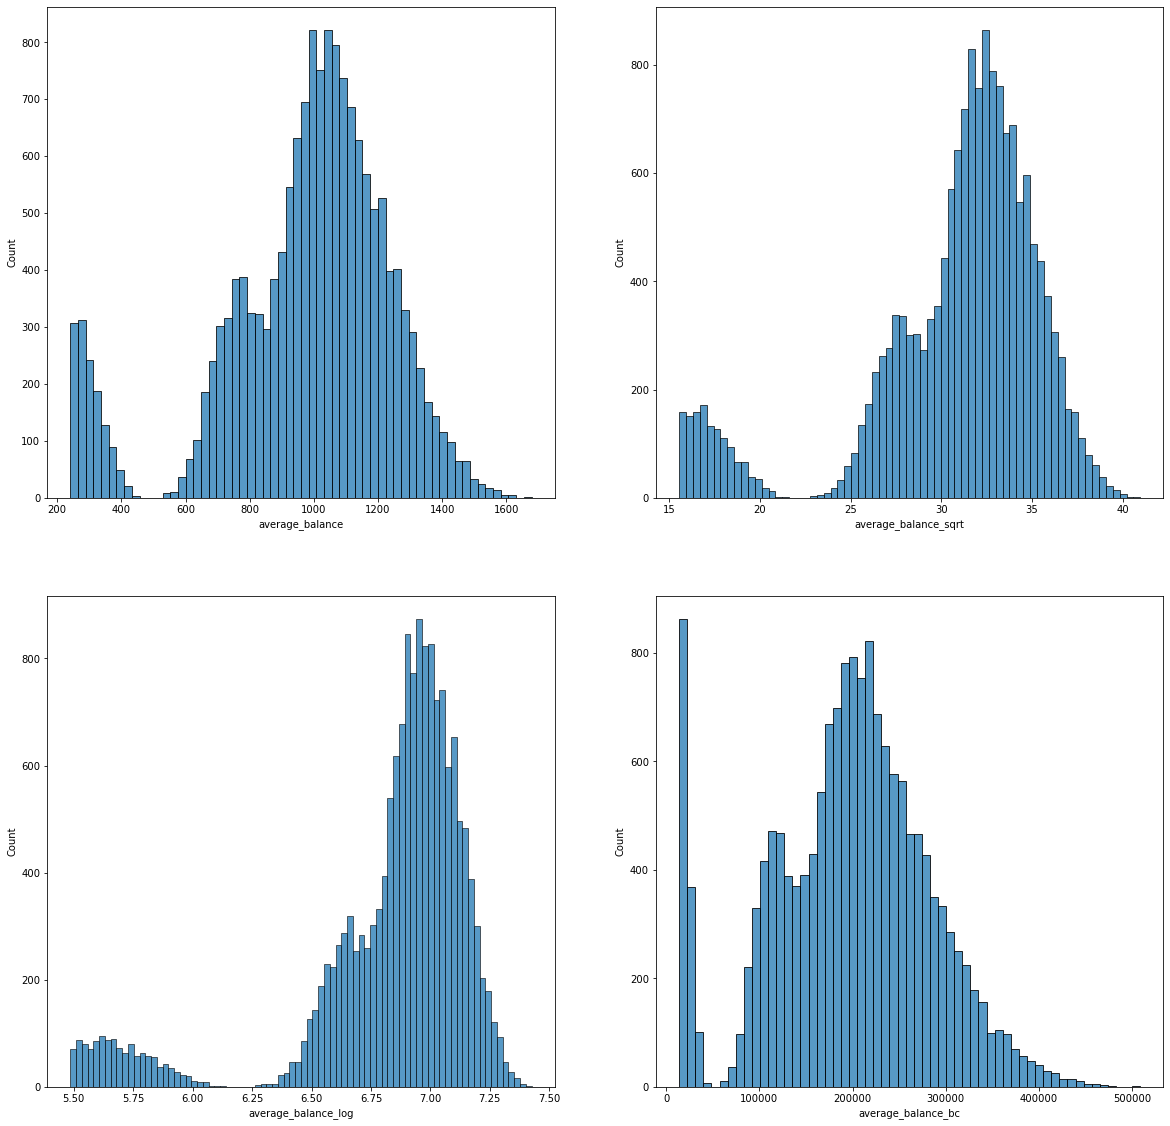

In [111]:
num = transformations(num, "q3_balance")
num = transformations(num, "min")
num = transformations(num, "average_balance")

In [112]:
#choose which transformations/columns to use
num = num[["min_sqrt", "q3_balance_sqrt", "average_balance"]] 

In [113]:
num.head()

min_sqrt  q3_balance_sqrt  average_balance
0  29.614186        33.090784          1160.75
2  12.041595        12.041595           276.50
3  20.469489        33.451457          1219.00
4  19.104973        31.336879          1211.00
5  22.293497        27.386128          1114.75

Apply scaling to numerical values

In [115]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(num)
num_standardized = transformer.transform(num)

In [120]:
num_standardized = pd.DataFrame(num_standardized)
num_standardized.columns = num.columns
num_standardized.head()

min_sqrt  q3_balance_sqrt  average_balance
0  1.383324         0.161081         0.693461
1 -1.165333        -2.446386        -2.554521
2  0.057014         0.205760         0.907422
3 -0.140889        -0.056183         0.878037
4  0.321561        -0.545583         0.524496

In [121]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(num)
num_normalized = transformer.transform(num)

In [123]:
num_normalized = pd.DataFrame(num_normalized)
num_normalized.columns = num.columns
num_normalized.head()

min_sqrt  q3_balance_sqrt  average_balance
0  0.025494         0.028487         0.999269
1  0.043468         0.043468         0.998109
2  0.016783         0.027428         0.999483
3  0.015769         0.025865         0.999541
4  0.019989         0.024555         0.999499

Categorical Encoding

In [124]:
cat.head()

offer_accepted     reward mailer_type income_level credit_rating  \
0             No  Air Miles      Letter         High          High   
2             No  Air Miles    Postcard         High        Medium   
3             No  Air Miles      Letter       Medium          High   
4             No  Air Miles      Letter       Medium        Medium   
5             No  Air Miles      Letter       Medium          High   

   household_size  
0               4  
2               2  
3               4  
4               6  
5               4

In [125]:
cat.shape

(16251, 6)

Encoding Categoricals - OneHot Encoder

In [126]:
from sklearn.preprocessing import OneHotEncoder

In [129]:
#assign target variable to y
y = cat["offer_accepted"]
cat = cat.drop(["offer_accepted"], axis = 1)

In [130]:
enc = OneHotEncoder(handle_unknown='error', drop='first')
cat_encoded = pd.DataFrame(enc.fit_transform(cat).toarray())


concat with Scaled Numerical

In [137]:
X = pd.DataFrame(np.concatenate([cat_encoded,num_normalized], axis =1))

In [138]:
X.head()

0    1    2    3    4    5    6    7    8    9    10   11        12  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.025494   
1  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.043468   
2  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.016783   
3  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.015769   
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.019989   

         13        14  
0  0.028487  0.999269  
1  0.043468  0.998109  
2  0.027428  0.999483  
3  0.025865  0.999541  
4  0.024555  0.999499

In [139]:
X.shape

(16251, 15)

Concatenate X with y and export to csv

In [140]:
data_preprocessed = pd.DataFrame(np.concatenate([X,pd.DataFrame(y)],axis=1))

In [141]:
data_preprocessed.to_csv('data_preprocessed.csv', index=False)